In [1]:
%pip install --upgrade librosa
%pip install --upgrade numba

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import obspy
import sys
import os
from scipy import stats,signal
import librosa
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
# import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Getting Data

In [3]:
os.chdir('data')
orca_df = pd.read_csv("orca_data.csv")
noise_df = pd.read_csv("noise_data.csv")

orca_df = orca_df.sample(n=len(orca_df)//20) # shape = (97, 3) whole // 20
noise_df = noise_df.sample(n=len(noise_df)//3) # shape = (107, 3) whole // 3
print(orca_df.shape)
print(noise_df.shape)

(97, 3)
(107, 3)


# Data Preparation

In [4]:
# os.makedirs('orca_spectrogram')
# os.makedirs('noise_spectrogram')

# Add column with labels to orca_df and noise_df, then merge the two together
orca_df['label'] = 1
noise_df['label'] = 0
data_df = pd.concat([orca_df, noise_df], ignore_index=True)
num_total_data = len(data_df) # 1 data = 1 row in df

In [5]:
dir_path = '/home/ajm76/OrcaSeis/data'

for index, row in data_df.iterrows():
    filename = row['wav_filename']
    filepath = 'wav/' + filename
    start_time = row['start_time_s']  # Keep in seconds
    end_time = row['end_time_s']  # Keep in seconds

    # Load the original wav file
    y, sr = librosa.load(filepath) # sr = 22050 for all
    
    # Convert start and end times to sample indices
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Extract the chunk
    chunk = y[start_sample:end_sample]

    # Generate a Short-Time Fourier Transform (STFT) spectrogram
    n_fft = 2048  # Window size (number of samples) - same as default
    hop_length = n_fft // 4  # Hop length - default is usually n_fft // 4
    window_type = 'hann'  # Window type - same as default
    D = librosa.stft(chunk, n_fft=n_fft, hop_length=hop_length, window=window_type)

    # Convert amplitude spectrogram to dB-scaled spectrogram
    spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        
    if spectrogram.shape[0] != 1025 and spectrogram.shape[1] != 44:
        print("wrong shape!")

    # Save the spectrogram as a NumPy array
    dir_name = ''
    if row['label'] == 1:
        dir_name = 'orca_spectrogram'
    else:
        dir_name = 'noise_spectrogram'
    np.save(os.path.join(dir_path, dir_name, str(index) + '.npy'), spectrogram)    

In [6]:
# start=-50
input_window_length=100 # in seconds
fs=22050 # target sampling rate

# number_data_per_class=100 # number of data samples per class
# num_channels=1  # number of components to check

# SNR_THR = 0

# all_data=False
# shifting=True
# augmentation=False


# training parameters
train_split = 80
val_split=10
test_split = 10
learning_rate=0.001
batch_size=8
n_epochs=60
dropout=0.2
criterion=nn.CrossEntropyLoss()

# Defining Model

In [7]:
class OrcaCNN(nn.Module):
    def __init__(self, num_classes=2, num_channels=1, dropout_rate=0.2):
        super(OrcaCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 253 * 8, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor before the fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2_bn(self.fc2(x))
        return x 

# Testing CNN model

In [8]:
# Assuming the input shape is (batch_size, num_channels, num_features)
# batch_size = 64  
num_channels = 1
num_features = 5000
# Create a random input tensor with the specified shape
random_input = torch.randn(batch_size, num_channels,int(input_window_length*fs)).to(device)
# Initialize your model
model = OrcaCNN(num_classes=2, num_channels=num_channels).to(device)  # Use 'cuda' if you have a GPU available
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in OrcaCNN in log10: {np.log10(total_params)}")

Total number of parameters in OrcaCNN in log10: 7.2209847391329935


In [9]:
from torch.utils.data import Dataset
class OrcaDataSet(Dataset): # create custom dataset
    def __init__(self, data, labels, num_classes): # initialize
        self.data = data 
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        sample_data = torch.Tensor(sample_data)
        sample_labels = torch.tensor(sample_labels).float()
        return sample_data, sample_labels

In [10]:
def train_model(model, train_loader, val_loader, test_loader, n_epochs=100,
                 learning_rate=0.001, criterion=nn.CrossEntropyLoss(),
                 augmentation=False, patience=10):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    val_loss_time = np.zeros(n_epochs)
    val_accuracy_time = np.zeros(n_epochs)

    best_val_loss = float('inf')
    total = 0   # to store the total number of samples
    correct = 0 # to store the number of correct predictions

    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()  # Convert labels to long

            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # computing the gradients
            loss.backward()

            # updating the parameters
            optimizer.step()

            running_loss += loss.item()

        # updating the training loss list
        loss_time[epoch] = running_loss/len(train_loader)

        # We evaluate the model, so we do not need the gradient
        model.eval()
        with torch.no_grad(): # Context-manager that disabled gradient calculation.
            # Loop on samples in test set
            total = 0
            correct = 0
            running_test_loss = 0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.float()
                labels = labels.long()  # Ensure labels are long

                outputs = model(inputs)
                running_test_loss += criterion(outputs, labels).item()

                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

    # Check for improvement
            if running_test_loss/len(val_loader) < best_val_loss:
                best_val_loss = running_test_loss/len(val_loader)
                epochs_no_improve = 0
                # Save the model if you want to keep the best one
                # torch.save(model.state_dict(), 'best_model.pth')
            else:
                epochs_no_improve += 1
                # print(f'No improvement in validation loss for {epochs_no_improve} epochs.')

            if epochs_no_improve == patience:
                # print('Early stopping triggered.')
                break

        
        val_loss_time[epoch] = running_test_loss/len(val_loader)

        val_accuracy_time[epoch] = 100 * correct / total
        # Print intermediate results on screen
        if (epoch+1) % 10 == 0:
            if val_loader is not None:
                print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
                (epoch + 1, running_loss/len(train_loader), 100 * correct / total))
            else:
                print('[Epoch %d] loss: %.3f' %
                (epoch + 1, running_loss/len(train_loader)))


    # Optionally, load the best model saved
    # model.load_state_dict(torch.load('best_model.pth'))
    # testing
    model.eval() 
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        total = 0
        correct = 0
        running_test_loss = 0
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()  # Ensure labels are long

            outputs = model(inputs)
            running_test_loss += criterion(outputs, labels).item()

            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        test_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * correct / total  
        print('test loss: %.3f and accuracy: %.3f' % ( test_loss, test_accuracy))
        
    return loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy

In [11]:
data_df

,wav_filename,start_time_s,end_time_s,label
0,9761900Y.wav,0.000000,1.000000,1
1,92304030.wav,0.000000,1.000000,1
2,97772009.wav,0.000000,1.000000,1
3,rpi-orcasound-lab_2020_09_01_15_34_00.wav,6.795667,7.795667,1
4,9750100J.wav,0.000000,1.000000,1
...,...,...,...,...
199,OS_9_27_2017_08_35_00__0003.wav,59.192383,60.192383,0
200,610620001.wav,0.000000,1.000000,0
201,61062.wav,0.000000,1.000000,0
202,1562337136_0012.wav,34.086437,35.086437,0


In [12]:
def normalize_spect(spect):
    mean = np.mean(spectrogram)
    std_dev = np.std(spectrogram)
    normalized_spectrogram = (spectrogram - mean) / std_dev
    return normalized_spectrogram

In [13]:
# Loading first sepctrogram, shape = ((1025, 44))
spectrogram_1 = np.load(os.path.join(dir_path, "orca_spectrogram", "1.npy"))

In [14]:
N = spectrogram_1.shape[0]
data = np.zeros(shape=(num_total_data, 1, N, spectrogram_1.shape[1]))
labels = np.zeros(num_total_data)
print(spectrogram_1.shape)

# Shuffling data_df
random.seed(1234)
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df

(1025, 44)


,wav_filename,start_time_s,end_time_s,label
0,97504019.wav,0.000000,1.000000,1
1,9750400I.wav,0.000000,1.000000,1
2,9750100M.wav,0.000000,1.000000,1
3,rpi-orcasound-lab_2020_09_01_15_34_00.wav,8.295667,9.295667,0
4,OS_9_27_2017_10_01_00__0001.wav,17.566840,18.566840,0
...,...,...,...,...
199,rpi-port-townsend_2020_09_29_19_06_00.wav,9.940650,10.940650,0
200,9777100F.wav,0.000000,1.000000,1
201,9769200N.wav,0.000000,1.000000,1
202,1562340736_0004.wav,36.750000,37.750000,0


In [15]:
# Populating data and labels arrays
non_existant_indices = []
for index, row in data_df.iterrows():
    file_name = str(index) + ".npy"
    
    cat_path = ""
    if row['label'] == 0:
        cat_path = 'noise_spectrogram'
    else:
        cat_path = 'orca_spectrogram'
    
    file_path = os.path.join(dir_path, cat_path, file_name)
    
    if os.path.exists(file_path):
        spectrogram = np.load(file_path)

        # Select window of data (first 100 points)
        spectrogram = spectrogram[:N, :]

        # Normalize using std deviation
        # spectrogram = normalize_spect(spectrogram)

        # Add spectrogram to data array
        data[index] = spectrogram

        # Populate labels array
        labels[index] = row['label'] 
    else:
        non_existant_indices.append(index)

data_tensor = torch.tensor(data)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [16]:
labels_tensor = labels_tensor.long()

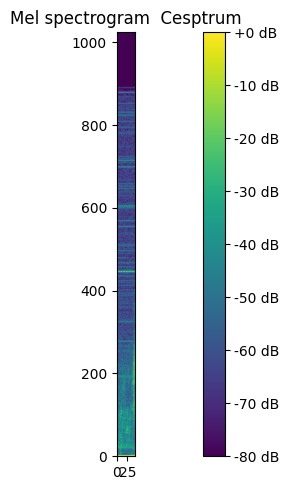

In [17]:
plt.figure(figsize=(14, 5))
plt.imshow(data[1][0], origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()

## Shuffle and split data

In [18]:
# Make the data a OrcaDataSet
custom_dataset = OrcaDataSet(data_tensor, labels_tensor, 2)
# first split train+val
# Determine the size of the training set
train_size = int(train_split/100 * len(custom_dataset)) # 80% of the data set
val_size = int(val_split/100 * len(custom_dataset)) # 10% of the data set
test_size = len(custom_dataset) - train_size - val_size # the rest is test
train_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size+val_size])
# then split val into val+test
test_dataset, val_dataset = random_split(val_dataset, [test_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
print(len(train_loader),len(val_loader),len(test_loader))

20 2 2


In [19]:
for batch_idx, (data, target) in enumerate(test_loader):
#     print(f"Batch {batch_idx}:")
#     print("Data:", data)
#     print("Target:", target)
#     print("\n")
    print(target.shape)

torch.Size([8])


/tmp/ipykernel_3232945/3778550383.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.tensor(sample_labels).float()


torch.Size([8])


## Training and Testing Models

In [20]:
# expects: input[8, 1, 1025] [batch_size, num_channels, sequence_length]

model = OrcaCNN(num_classes=2, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy = train_model(model,
    train_loader,val_loader,test_loader,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation=False)

/tmp/ipykernel_3232945/3778550383.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.tensor(sample_labels).float()


[Epoch 10] loss: 0.329 - accuracy: 87.500
test loss: 0.452 and accuracy: 81.250


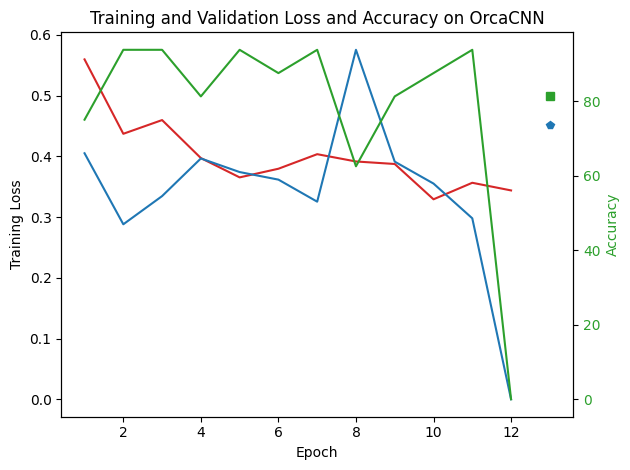

In [22]:
NN = np.count_nonzero(loss_time)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.plot(np.arange(1, NN+1), loss_time[:NN], color='tab:red')
ax1.plot(np.arange(1, NN+1), val_loss_time[:NN], color='tab:blue')
ax1.plot(NN+1, test_loss, 'p', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:green')
ax2.plot(np.arange(1, NN+1), val_accuracy_time[:NN], color='tab:green')
ax2.plot(NN+1, test_accuracy, 's', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
plt.title("Training and Validation Loss and Accuracy on OrcaCNN")
fig.tight_layout()
plt.show()
# plt.savefig("OrcaCNN.png")